In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Disaster_Tweets

/content/drive/My Drive/Disaster_Tweets


In [3]:
!pip install -r requirements.txt


# 1. Thêm các thư viện cần sử dụng

In [4]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

In [5]:
%cd /content/drive/My Drive/Disaster_Tweets/src


/content/drive/My Drive/Disaster_Tweets/src


Đọc dữ liệu đã được tiền xử lý: `light_pre_train_3.csv` và `light_pre_test_3.csv` vào 2 dataframe: `train_df` và `test_df`

In [6]:
train_df = pd.read_csv('../preprocessing/light_pre_train_4.csv')
test_df = pd.read_csv('../preprocessing/light_pre_test_4.csv')

# 2. Chuẩn bị dữ liệu

## 2.1 Tổng quan:
- Chia dữ liệu trên `train_df` theo tỉ lệ `70:30` tương ứng để fine tune trên mô hình BERT với 70% dữ liệu và đánh giá mô hình trên 30% dữ liệu còn lại.

- Sao chép 100% dữ liệu trên `train_df` sang `train_df_shuffle`, sau đó xáo trộn 100% dữ liệu đó, và tiếp tục fine tune với mô hình BERT đã được fine tuning trước đó, trước khi nộp bài đánh giá trên kaggle.

- Dùng mô hình pretrained `bert-base-uncased` (tiếng anh) và module BertTokenizer từ thư viện `transformer` để tokenize văn bản(text) thành vector tương ứng. Thực hiện trên cả train_df, test_df và train_df_shuffle.

- Dựa vào số lượng token (từ) được tách ra (tokenize) từ các câu trên train_df, để lựa chọn `max_length` - số chiều của vector embedding khi fine tune bằng mô hình BERT.


## 2.2 Sao chép và xáo trộn dữ liệu

Sao chép dữ liệu `train_df` sang `train_df_shuffle` và xáo xộn nó.

In [7]:
train_df_shuffle = train_df.sample(frac=1, random_state=12)

In [8]:
train_df_shuffle


,id,keyword,location,text,target
6169,9087,structural failure,NaN,virgin galactic crash early unlocking of brake...,1
6540,9657,thunderstorm,NaN,usnwsgov severe weather statement issued augus...,1
3689,5378,fire truck,NaN,our garbage truck really caught on fire laugh ...,0
1288,1918,burning,NaN,ika tuning soup diet recipes fat burning soup ...,0
4606,6731,lava,"Bandar Lampung, Indonesia",youngheroesid lava blast dan power red panther...,1
...,...,...,...,...,...
3714,5413,first responders,Texas,usatoday praying for god s healing and safety ...,0
3325,4891,explode,NaN,learn how i gained access to the secrets of th...,0
1414,2097,casualty,In @4SkinChan 's arms,reriellechan he was the lich king s first casu...,1
5787,8517,screaming,Namjoon's pants,how do people not know who kendall jenner is s...,0


Lấy text và target trong `train_df_shuffle`

In [9]:

all_train_labels = train_df_shuffle.target
all_train_text = train_df_shuffle.text

Lấy ra cột `text`, `target` trên `train_df` và cột `text` trên `test_df`

In [10]:
train_text = train_df.text
train_labels = train_df.target
test_text = test_df.text

## 2.3 Tokenine văn bản và lựa chọn siêu tham số max_length

Cài đặt thư viện transformer

In [11]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.1 MB/s eta 0:00:00


`BertTokenizer`: dùng để token văn bản thành vector


In [12]:
from transformers import BertTokenizer,TFBertForSequenceClassification

Dùng pretrained `bert-base-uncased` để tokenize văn bản thành vector.

In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Tokenize trên `train_text`

In [14]:
token_lens = []
for txt in list(train_text):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

In [15]:
tokenizer.encode("Hoang Duc Nhat", max_length=512, truncation=True)

[101, 7570, 5654, 26363, 18699, 4017, 102]

Ở đây max_length = 512 sẽ giới hạn là độ dài của mỗi câu. Nếu câu nào có độ dài lớn hơn 512, thì sẽ cắt bỏ (truncation = True). Tuy nhiên, toàn bộ các câu trong bộ corpus không tồn tại câu nào có độ dài lớn như vậy. Ta thử xem phân phối của chúng trên tập train.

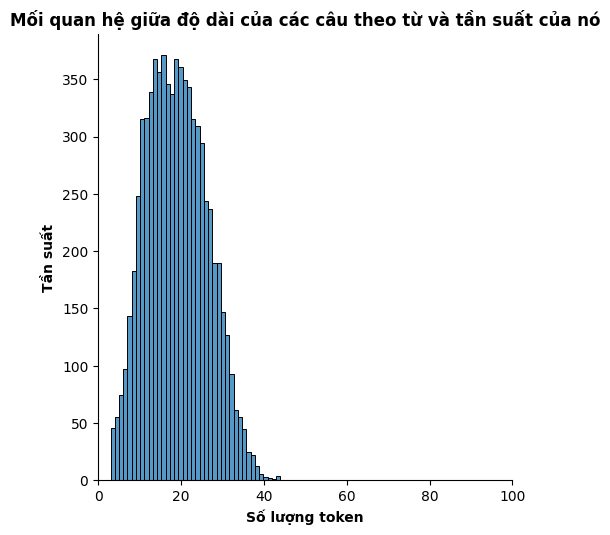

In [16]:
sns.displot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Số lượng token', fontweight = "bold")
plt.ylabel('Tần suất', fontweight = "bold")
plt.title("Mối quan hệ giữa độ dài của các câu theo từ và tần suất của nó", fontweight = "bold")
plt.show()

Dựa vào đồ thị, ta sẽ chọn siêu tham số `max_lengh` = 45 hoặc 50 hoặc 64 để train mô hình.

# 2. Chuyển text thành vector tương ứng trong bộ vocabulary lấy từ pretrained bert-base-uncased

In [17]:
MAX_SEQ_LEN = 50

In [18]:
def bert_tokenizer(text):
    encoding = tokenizer.encode_plus(
    text,
    max_length=MAX_SEQ_LEN,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
    )
    return encoding['input_ids'][0], encoding['attention_mask'][0]

In [19]:
bert_tokenizer("Hoang Duc Nhat Minh")

(tensor([  101,  7570,  5654, 26363, 18699,  4017, 19538,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]))

Chuyển text thành vector trên tập `train_text`, và lưu vào `train_tokenized_list`

In [20]:
train_tokenized_list = []
train_attn_mask_list = []
for text in list(train_text):
    tokenized_text, attn_mask = bert_tokenizer(text)
    train_tokenized_list.append(tokenized_text.numpy())
    # train_attn_mask_list.append(attn_mask.numpy())

Chuyển text thành vector trên tập `test_text`, và lưu vào `test_tokenized_list`.

In [21]:
# test data tokenization for testing
test_tokenized_list = []
test_attn_mask_list = []
for text in list(test_text):
    tokenized_text, attn_mask = bert_tokenizer(text)
    test_tokenized_list.append(tokenized_text.numpy())
    # test_attn_mask_list.append(attn_mask.numpy())

Chuyển text thành vector trên tập `all_train_text`, và lưu vào `test_tokenised_text_df`

In [22]:
all_train_tokenized_list = []
for text in list(all_train_text):
    tokenized_text, attn_mask = bert_tokenizer(text)
    all_train_tokenized_list.append(tokenized_text.numpy())

Chuyển `train_tokenized_list`, `all_train_tokenized_list` và `test_tokenized_list` sang dạng dataframe

In [23]:
train_tokenised_text_df = pd.DataFrame(train_tokenized_list)
all_train_tokenised_text_df = pd.DataFrame(all_train_tokenized_list)
test_tokenised_text_df = pd.DataFrame(test_tokenized_list)

Từ `train_tokenized_text_df` chia thành 70% `X_train` và 30% `X_val`

In [24]:
X_train, X_val, y_train, y_val = train_test_split(train_tokenised_text_df, train_labels, test_size=0.1, random_state=4)

In [25]:
print(f'X_train input shape {X_train.shape}, train label shape {y_train.shape}')
print(f'X_val input shape {X_val.shape}, validation label shape {y_val.shape}')

X_train input shape (6656, 50), train label shape (6656,)
X_val input shape (740, 50), validation label shape (740,)


# 3. Fine tune trên mô hình BERT

## 3.1 Tổng quan
Giai đoạn 1: Fine tune với mô hình BERT trên `X_train` (70% dữ liệu) và đánh giá trên `X_val` (30%) với 2 epoch.

Giai đoạn 2: Tiếp tục fine tune trên `all_train_text` với cấu hình: learning rate 5e-6, 1 epoch.

Các siêu tham số (hyperparameter) được dùng để tuning:
- `Learning rate` ở cả 2 giai đoạn.
- `max_length`: số lượng chiều của vector feature embedding, với các giá trị 45, 50, 55, 64.


## 3.2 Xây dựng hàm đánh giá mô hình

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [27]:
# Đánh giá mô hình
def eval_model(predictions):
    print(accuracy_score(y_val, predictions))
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(np.array(y_val), np.array(predictions))
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print(classification_report(y_val, np.array(predictions), target_names=["not disaster", "disaster"]))

## 3.3 Chi tiết

### 3.3.1 Giai đoạn 1: Fine tune với mô hình BERT trên `X_train` (70% dữ liệu) và đánh giá trên `X_val` (30%)

Lấy số lượng class của dữ liệu

In [28]:
num_classes = len(train_labels.unique())
num_classes

2

Gọi mô hình pretrained `TFBertForSequenceClassification`


In [29]:
from transformers import TFBertForSequenceClassification

In [30]:
bertClassifier = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
print('\nBert Model', bertClassifier.summary())

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


Cấu hình hàm loss, optimizer, metric
- Hàm loss: cross entropy
- Optimizer: Adam
- Callback ModelCheckpoint: lưu mô hình
- Learning rate: 1e-5

In [31]:
checkpoint_path = "./models/my_bert.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 verbose=1)



loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bertClassifier.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Fine tune mô hình với batch_size = 32 và 2 epoch

In [32]:
bertHistory = bertClassifier.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=3,
                       validation_data=(X_val, y_val),
                       callbacks=[model_callback])

Epoch 1/3
208/208 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.7906
Epoch 1: val_loss improved from inf to 0.40888, saving model to ./models/my_bert.ckpt


208/208 [==============================] - 180s 648ms/step - loss: 0.4654 - accuracy: 0.7906 - val_loss: 0.4089 - val_accuracy: 0.8243
Epoch 2/3
208/208 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8636
Epoch 2: val_loss did not improve from 0.40888
208/208 [==============================] - 70s 338ms/step - loss: 0.3451 - accuracy: 0.8636 - val_loss: 0.4288 - val_accuracy: 0.8257
Epoch 3/3
208/208 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.9035
Epoch 3: val_loss did not improve from 0.40888
208/208 [==============================] - 67s 324ms/step - loss: 0.2617 - accuracy: 0.9035 - val_loss: 0.4690 - val_accuracy: 0.8189


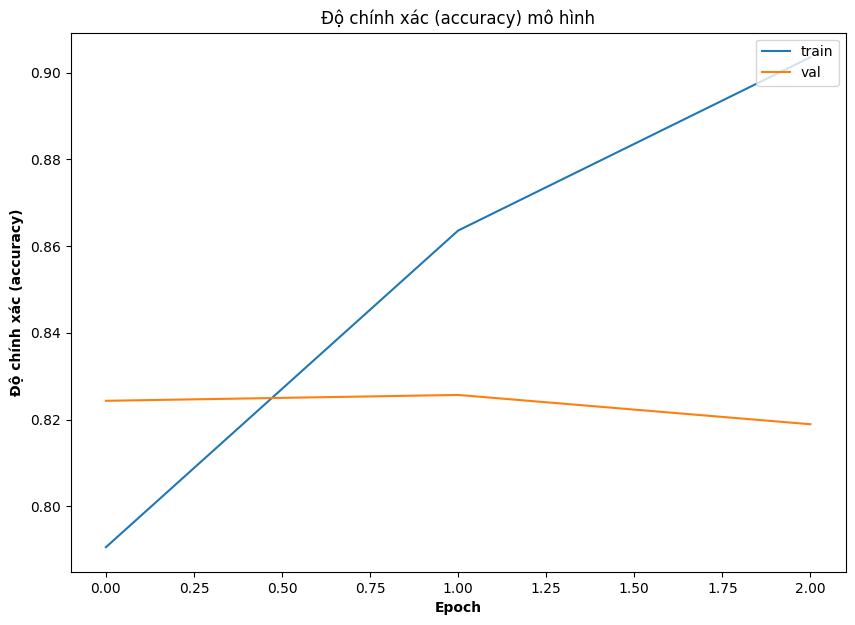

In [33]:
plt.figure(figsize=(10, 7))
plt.plot(bertHistory.history['accuracy'])
plt.plot(bertHistory.history['val_accuracy'])
plt.title('Độ chính xác (accuracy) mô hình')
plt.ylabel('Độ chính xác (accuracy)', fontweight = "bold")
plt.xlabel('Epoch', fontweight = "bold")
plt.legend(['train', 'val'], loc='upper right')
plt.show()

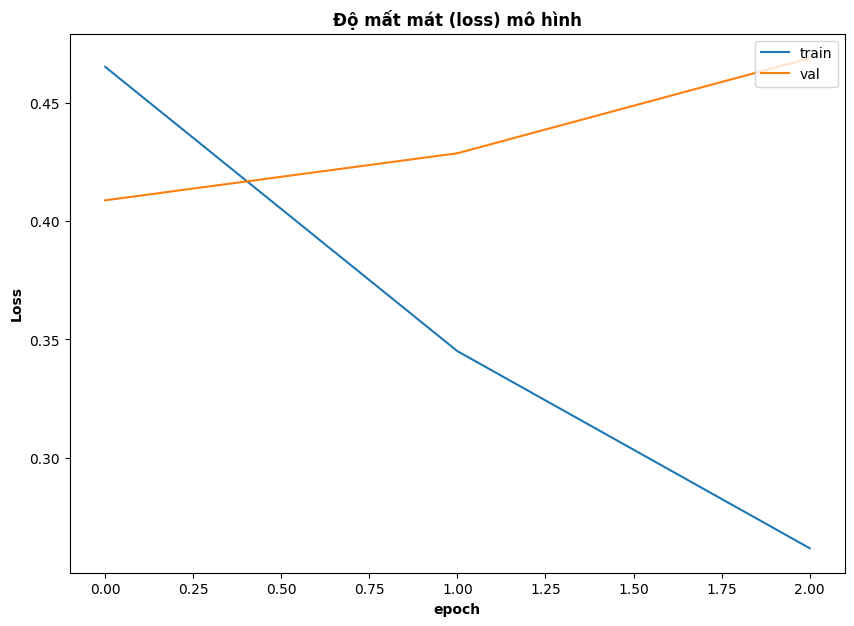

In [34]:
plt.figure(figsize=(10, 7))
plt.plot(bertHistory.history['loss'])
plt.plot(bertHistory.history['val_loss'])
plt.title('Độ mất mát (loss) mô hình', fontweight = 'bold')
plt.ylabel('Loss', fontweight = "bold")
plt.xlabel('epoch', fontweight = "bold")
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### 3.3.2 Giai đoạn 2: Tiếp tục fine tune trên `all_train_text` với cấu hình: learning rate 5e-6, 1 epoch

In [35]:
bertClassifier.load_weights(checkpoint_path)

Cấu hình lại hàm optimizer với learning rate nhỏ hơn, và bằng 5e-6

In [36]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate = 5e-7,epsilon=1e-08)

bertClassifier.compile(loss=loss,optimizer=optimizer2,metrics=[metric])

Fine tune mô hình với 1 epoch

In [37]:
history_all = bertClassifier.fit(all_train_tokenised_text_df,
                       all_train_labels,
                       batch_size=32,
                       epochs=1)

232/232 [==============================] - 138s 374ms/step - loss: 0.3485 - accuracy: 0.8584


In [38]:
# predictions
test_pred_all = bertClassifier.predict(X_val)
tensor_test_predictions_all = tf.math.softmax(test_pred_all.logits, axis=1)
print(tensor_test_predictions_all)

# then use argmax after softmax to turn into labels
test_predictions_all = [list(bertClassifier.config.id2label.keys())[i] for i in tf.math.argmax(tensor_test_predictions_all, axis=1).numpy()]

24/24 [==============================] - 6s 106ms/step
tf.Tensor(
[[0.90684617 0.09315383]
 [0.9273844  0.07261568]
 [0.88603324 0.11396682]
 ...
 [0.6899819  0.3100181 ]
 [0.8100144  0.18998556]
 [0.90436924 0.09563078]], shape=(740, 2), dtype=float32)


0.8162162162162162


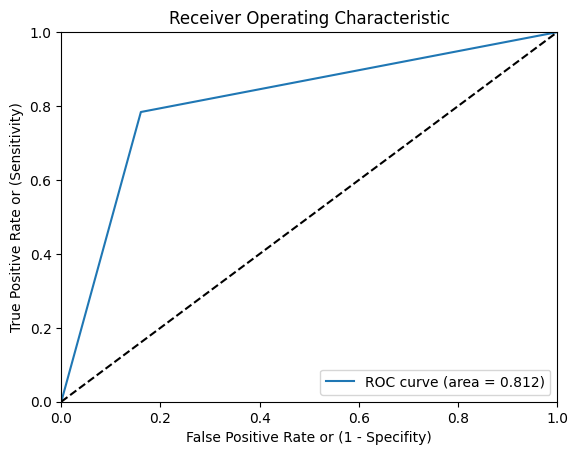

              precision    recall  f1-score   support

not disaster       0.84      0.84      0.84       430
    disaster       0.78      0.78      0.78       310

    accuracy                           0.82       740
   macro avg       0.81      0.81      0.81       740
weighted avg       0.82      0.82      0.82       740



In [39]:
eval_model(test_predictions_all)

# 4. Dự đoán mô hình trên tập test và nộp bài lên Kaggle

In [40]:
submitted_prediction = bertClassifier.predict(test_tokenised_text_df)
print(submitted_prediction)

102/102 [==============================] - 12s 115ms/step
TFSequenceClassifierOutput(loss=None, logits=array([[-1.7696528 ,  1.8913646 ],
       [-1.6554818 ,  1.8070903 ],
       [-1.6824783 ,  1.8634197 ],
       ...,
       [-1.9155623 ,  2.0071843 ],
       [-1.4590919 ,  1.5593586 ],
       [-0.48296866,  0.71366036]], dtype=float32), hidden_states=None, attentions=None)


In [41]:
submitted_prediction = tf.math.softmax(submitted_prediction.logits, axis=1)
print(submitted_prediction)

tf.Tensor(
[[0.02506209 0.974938  ]
 [0.03039614 0.96960384]
 [0.02803413 0.9719659 ]
 ...
 [0.01940276 0.9805972 ]
 [0.04659927 0.95340073]
 [0.23207542 0.76792455]], shape=(3263, 2), dtype=float32)


Dùng hàm softmax để suy ra nhãn của từng mẫu dữ liệu

In [42]:
submitted_prediction = [list(bertClassifier.config.id2label.keys())[i] for i in tf.math.argmax(submitted_prediction, axis=1).numpy()]

In [43]:
print(submitted_prediction)

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [46]:
df_sample = pd.read_csv('../dataset/sample_submission.csv')
df_sample['target'] = submitted_prediction
df_sample.to_csv(r'my_bert_official.csv', index=False)

# 5. Giới thiệu về mô hình BERT

- BERT là viết tắt của từ Bidirectional Encoder Representation from Transformer nghĩa là mô hình biểu diễn từ theo 2 chiều ứng dụng kỹ thuật Transformer.
- Được train trên Wikipedia (~2.5B words) và Google’s BooksCorpus (~800M words)
- Mô hình BERT nhóm sử dụng: bert-base-uncased với 110 triệu tham số. Với base tương ứng với 12 encoder layer, và uncased phù hợp sử dụng cho các ngôn ngữ không dấu, như tiếng anh. 



1. Ở bước tokenizer (chuyển một đoạn văn bản thô sang dạng vector tương ứng):
- Index: Chuyển đoạn văn bản thô sang một vector số tương ứng, mỗi từ tương ứng với một con số, và con số này được lấy ra từ bộ vocabulary.
- Index Type: giúp việc phân biệt giữa các câu, một từ (token) thuộc câu nào. Nhưng đối với bài toán này, ta không dùng đến vector này. Còn gọi là segment embedding.
- Binary Mask: Phân biệt chỗ nào là có dữ liệu, chỗ nào là không có dữ liệu.

2. Thêm 4 token: [CLS], [SEP], [UNK], [PAD]
- Token [CLS] - bắt đầu câu, CLS là viết tắt của từ classifier, được dùng cho nhiệm vụ classification.
- Token [SEP] - kết thúc câu
- Token [UNK] - Dùng cho các token không nằm trong bộ vocab.
- Token [PAD] - Padding cho các vector embedding đối với những câu có chiều dài khác nhau.